In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.model_selection import cross_val_score, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [2]:
# Load datasets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Copy to avoid modifying original data
train = train.copy()
test = test.copy()


In [3]:
def preprocess(df):
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    df['IsAlone'] = (df['FamilySize'] == 1).astype(int)
    df['Title'] = df['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)

    rare_titles = ['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major',
                   'Rev', 'Sir', 'Jonkheer', 'Dona']
    df['Title'] = df['Title'].replace(rare_titles, 'Rare')
    df['Title'] = df['Title'].replace({'Mlle': 'Miss', 'Ms': 'Miss', 'Mme': 'Mrs'})

    df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)
    if df['Fare'].isnull().any():
        df['Fare'].fillna(df['Fare'].median(), inplace=True)

    title_mapping = {'Mr': 0, 'Miss': 1, 'Mrs': 2, 'Master': 3, 'Rare': 4}
    df['Title'] = df['Title'].map(title_mapping).fillna(4).astype(int)

    df['Sex'] = df['Sex'].map({'male': 0, 'female': 1}).astype(int)
    df['Embarked'] = df['Embarked'].map({'S': 0, 'C': 1, 'Q': 2}).astype(int)

    median_ages = df.groupby(['Sex', 'Pclass', 'Title'])['Age'].median()

    def fill_age(row):
        if pd.isnull(row['Age']):
            return median_ages.loc[row['Sex'], row['Pclass'], row['Title']]
        else:
            return row['Age']

    df['Age'] = df.apply(fill_age, axis=1)

    df.drop(columns=['Name', 'Ticket', 'Cabin', 'SibSp', 'Parch'], inplace=True, errors='ignore')

    return df


In [4]:
train_df = preprocess(train)
test_df = preprocess(test)

X_train = train_df.drop('Survived', axis=1)
y_train = train_df['Survived']
X_test = test_df.copy()


In [5]:
# Define base models
estimators = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('xgb', xgb.XGBClassifier(eval_metric='logloss', random_state=42, verbosity=0))
]

# Define stacking classifier with logistic regression as final estimator
stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(max_iter=1000),
    cv=5
)

# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(stacking_clf, X_train, y_train, cv=cv, scoring='accuracy')
print(f'Stacking CV Accuracy: {cv_scores.mean():.4f} +/- {cv_scores.std():.4f}')

Stacking CV Accuracy: 0.8350 +/- 0.0129


In [6]:
# Train stacking classifier on full data
stacking_clf.fit(X_train, y_train)

# Predict on test set
predictions = stacking_clf.predict(X_test)

# Prepare submission
submission = pd.DataFrame({
    'PassengerId': test['PassengerId'],
    'Survived': predictions
})
submission.to_csv('submission.csv', index=False)
print('Submission saved as submission.csv')

Submission saved as submission.csv


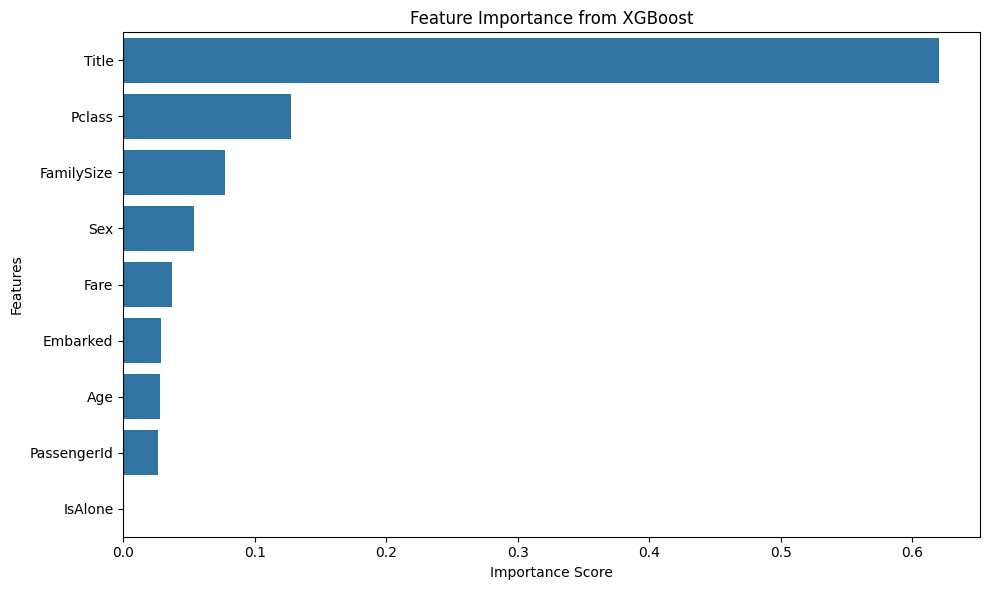

In [7]:
# Feature importance plot for XGBoost
xgb_model = stacking_clf.named_estimators_['xgb']
importance = xgb_model.feature_importances_

feat_imp = pd.Series(importance, index=X_train.columns).sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=feat_imp, y=feat_imp.index)
plt.title('Feature Importance from XGBoost')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.savefig('feature_importance.png')
plt.show()

<Figure size 600x600 with 0 Axes>

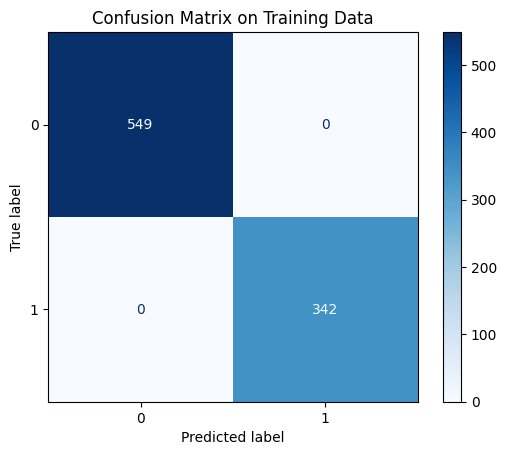

In [8]:
# Confusion matrix on training data
y_pred_train = stacking_clf.predict(X_train)
cm = confusion_matrix(y_train, y_pred_train)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=stacking_clf.classes_)

plt.figure(figsize=(6,6))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix on Training Data')
plt.savefig('confusion_matrix.png')
plt.show()